# Satellite Trail Masking Techniques

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

Even though Hubble has a small field of view, satellites are commonly captured in images. The cosmic ray rejection algorithm in Astrodrizzle is not well suited to eliminate satellite trails, and the affected adjacent pixels that make up their wings leave ugly blemishes in stacked images. 

To fix this problem, the pixels around satellite trails need to be marked as bad in the affected images. There are several ways to do this. The ACS Team has developed multiple algorithms to automatically detect and mask satellite trails. This is the easiest and most convenient way. Masks can also be made manually using DS9 regions. While not as convenient, making masks manually allows you to mask not only satellites, but also any other anomalies with odd shapes (e.g. dragon's breath, glint, blooming). 

Both methods are explained below. 

In [1]:
import os
import shutil

from astropy.io import fits
from astroquery.mast import Observations
from astropy.visualization import astropy_mpl_style, ImageNormalize, LinearStretch
from IPython.display import Image
import matplotlib.pyplot as plt
import pyregion

import acstools
from acstools.findsat_mrt import WfcWrapper
from acstools.utils_findsat_mrt import update_dq
from acstools.satdet import detsat, make_mask
from astropy.nddata import block_replicate
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

%matplotlib inline



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


Use the following cell to select which data set you want to run this notebook on.

## 1. Download the Data

The images to be used are the F814W images of visit B7 from GO program [13498](http://www.stsci.edu/cgi-bin/get-proposal-info?id=13498&observatory=HST). These come from the Hubble Frontier Fields program and are images of the the galaxy cluster MACSJ0717.5+3745. 

There are four dithered exposures in the association to be downloaded.

In [2]:
obsid = 'JC8MB7020'
project = 'CALACS'
flc_file = 'jc8mb7tcq_flc.fits'  # this is the individual FLC file containing a satellite trail

In [3]:
# Searching for the observsation
results = Observations.query_criteria(obs_id=obsid, obstype='all')

# Downloading previews and FLC files
jpg_download = Observations.download_products(results['obsid'], mrp_only=False, extension=['jpg'], project=project)
flc_download = Observations.download_products(results['obsid'], productSubGroupDescription=['FLC'], mrp_only=False, project=project)

  warnings.warn("Filter {} does not exist. This filter will be skipped.".format(colname), InputWarning)

INFO:astroquery:Found cached file ./mastDownload/HST/jc8mb7sqq/jc8mb7sqq_raw.jpg with expected size 1650656.
INFO:astroquery:Found cached file ./mastDownload/HST/jc8mb7sqq/jc8mb7sqq_flc.jpg with expected size 1669831.


INFO: Found cached file ./mastDownload/HST/jc8mb7sqq/jc8mb7sqq_raw.jpg with expected size 1650656. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jc8mb7sqq/jc8mb7sqq_flc.jpg with expected size 1669831. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HST/jc8mb7sqq/jc8mb7sqq_flt.jpg with expected size 1774640.


INFO: Found cached file ./mastDownload/HST/jc8mb7sqq/jc8mb7sqq_flt.jpg with expected size 1774640. [astroquery.query]


In [4]:
# Cleaning up directories after downloading from MAST
if os.path.exists('mastDownload'):
    for file in jpg_download['Local Path']:
        if 'drc' in file:
            os.rename(file, os.path.basename(file))

    for file in flc_download['Local Path']:
        os.rename(file, os.path.basename(file))

    shutil.rmtree('mastDownload')

else:
    pass

The image below shows the combined drizzled image from this association. The satellite trail can be seen going across the image from left to right, just above the center of the image. 

In [5]:
Image(filename=obsid.lower() + '_drc.jpg', width=900, height=900)

The bright satellite trail that caused this came from the image *jc8mb7cq_flc.fits*. The figure below shows the top chip which is referred to as SCI,2 (or extension 4). 

In [ ]:
plt.style.use(astropy_mpl_style)
img = fits.getdata('jc8mb7tcq_flc.fits', ext=4)

norm1 = ImageNormalize(img, vmin=100, vmax=200, stretch=LinearStretch())
#plt.figure(figsize=(16, 16))
fig,ax=plt.subplots(figsize=(16,16))
c=ax.imshow(img, norm=norm1, cmap='gray_r', origin='lower')
plt.colorbar(c,orientation='horizontal')
plt.grid()


## 2. Automated tools for masking satellites

The ACS Team developed multiple algorithms to automatically detect and mask satellite trails. The newest is a module called `findsat_mrt` and is decribed in [ISR ACS 2022-08](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf). The 'readthedocs' page can be found here: [MRT-based Satellite Trail Detection](https://acstools.readthedocs.io/en/latest/findsat_mrt.html). The second module is called `satdet` and is described in [ISR ACS 2016-01](http://www.stsci.edu/hst/acs/documents/isrs/isr1601.pdf).  The 'readthedocs' page for the software can be found here: [Satellite Trails Detection](https://acstools.readthedocs.io/en/stable/satdet.html). `findsat_mrt` has the benefit of significantly improved sensitivity over `satdet` but it is more computationally demanding. We demonstrate both approaches below.

### 2a. Using findsat_mrt

The `WfcWrapper` class provides a simple one-line approach to creating a mask for satellite trails. In this example, we run `WfcWrapper` on the top chip only (SCI,1 or extension 4). `WfcWrapper` loads the data, prepares the image (applies rebinning, removes a background, and masks already identified bad pixels), and executes the detection routines. In this example, we rebin the data by 2 pixels in each direction and use 8 processes. You may want to adjust the binning and/or number of processes depending on your system. We also set a maximum trail width of 75 pixels (this can also be adjusted depending on your binning).

In [7]:
w = WfcWrapper('jc8mb7tcq_flc.fits', 
               extension=4, 
               binsize=2, 
               processes=8, 
               max_width=75,
               preprocess=True, 
               execute=True)

INFO:findsat_mrt:image type is flc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2
INFO:findsat_mrt:Running the trailfinding pipeline
INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 3
INFO:findsat_mrt:3 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 3
INFO:findsat_mrt:3 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 9
INFO:findsat_mrt:9 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:f

INFO:utils_findsat_mrt:width of feature = 54.759918904481964
INFO:utils_findsat_mrt:breaking into 3.0 sections for persistence check
Section size for persistence check: 482.0
INFO:utils_findsat_mrt:Checking persistence, step 1 of 3
INFO:utils_findsat_mrt:amplitude of feature: 11.143102130332087
baseline noise: 3.9977546182935537
snr of feature = 1.787340193252915
INFO:utils_findsat_mrt:width of feature = 109.38799918393812
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.787340193252915, 109.38799918393812, 253.42424114602628
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 3
INFO:utils_findsat_mrt:amplitude of feature: 8.293189890604788
baseline noise: 4.119814334184495
snr of feature = 1.0130008825376837
INFO:utils_findsat_mrt:width of feature = 27.56080182155449
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0130008825376837, 27.56080182155449, 250.99432014737073
INFO:utils_findsat_mrt:fit failed, will not update gue

We can plot the mask on its own, or overlaid on the input image. 

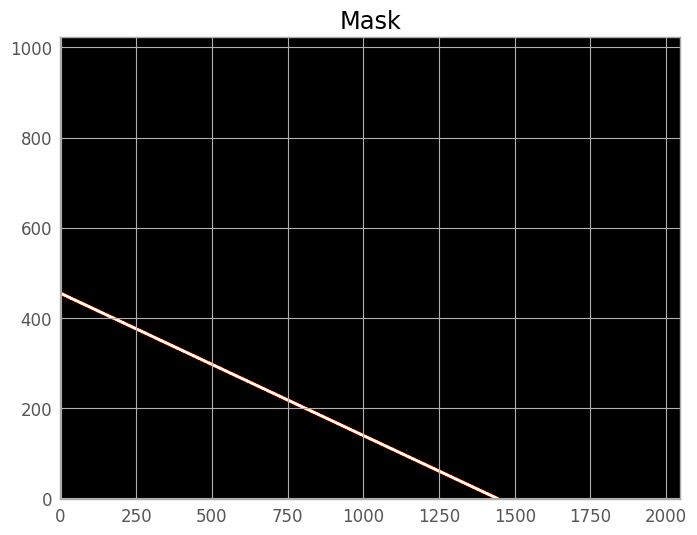

In [ ]:
w.plot_mask()
w.plot_image(overlay_mask=True)

We clearly see the mask covering the satellite trail. The call to `WfcWrapper` above works well for most ACS/WFC data, but if you want to adjust the parameters, please see the documentation for `acstools.findsat_mrt`.

The mask created by `WfcWrapper` casts a pretty wide net around the trail it finds, but there may be situations where you need to broaden it further. The `skimage.morphology.dilation` routine is one way to do this.

In [9]:
from skimage.morphology import dilation
from skimage.morphology import square
mask_mrt = dilation(w.mask,square(5))  # adjust the box size to whatever you need
w.mask = mask_mrt  # add the mask into the WfcWrapper instance


### 2b. Using satdet

The first command below runs the detection algorithm on the top chip only (extension 4) and generates some diagnostic plots. Note that the images are shown upside down from the figure above. 

1 file(s) found...

Processing jc8mb7tcq_flc.fits[4]...
Rescale intensity percentiles: 112.70187335968018, 173.3810810852051
Length of PHT result: 33
min(x0)=   1, min(x1)= 462, min(y0)= 110, min(y1)=   1
max(x0)=2535, max(x1)=2918, max(y0)= 921, max(y1)= 762
buf=200
topx=3896, topy=1848
trail_angle: [-17.50332521 -17.49606261 -17.49936604 -17.43425095 -17.48969533
 -17.50490423 -17.49496779 -17.49854844 -17.53449991 -17.49232453
 -17.48918144 -17.47477426 -17.52556837 -17.49373467 -17.49854844
 -17.45798387 -17.47186651 -17.42225011 -17.50924479 -17.49307304
 -17.52556837 -17.46575177 -17.50280938 -17.5063459  -17.36948491
 -17.50086127 -17.30849158 -17.06869861 -17.4944733  -16.98473253
 -17.42276121 -17.49975656 -17.42714325]
round_angle: [-20 -15 -15 -15 -15 -20 -15 -15 -20 -15 -15 -15 -20 -15 -15 -15 -15 -15
 -20 -15 -20 -15 -20 -20 -15 -20 -15 -15 -15 -15 -15 -15 -15]
mode(round_angle): -15
Filtered trail_angle: [-17.49606261 -17.49936604 -17.43425095 -17.48969533 -17.49496779
 -

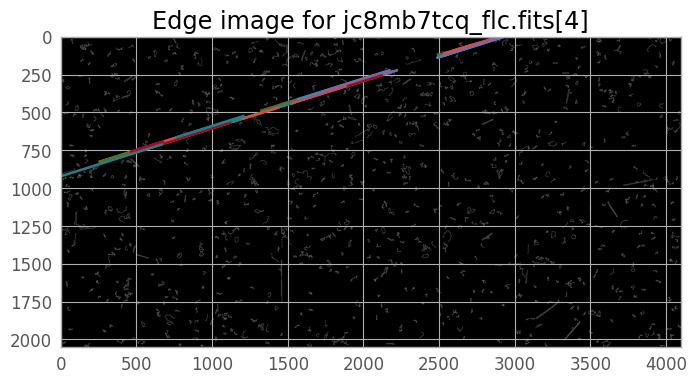

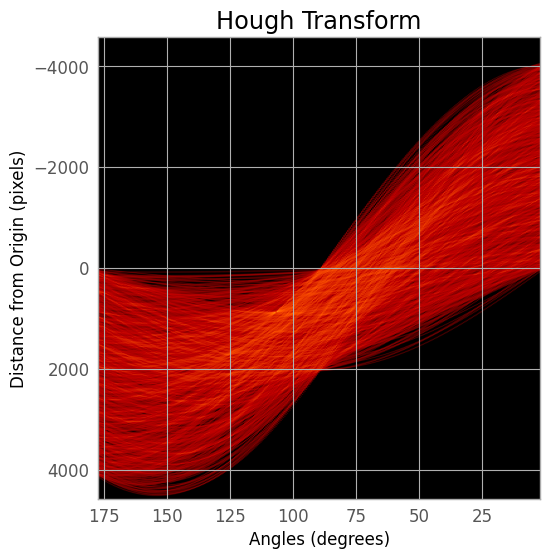

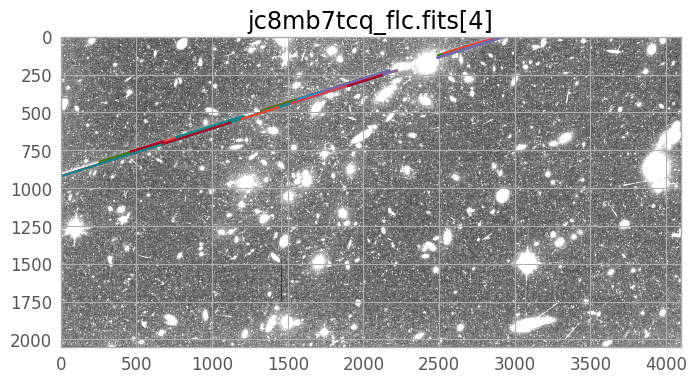

In [10]:
results, errors = detsat('jc8mb7tcq_flc.fits',
                         chips=[4],
                         n_processes=4,
                         plot=True,
                         verbose=True)
#                         percentile=(1,99))

The diagnostic plots can be used to verify that the satellite was properly detected. Changing parameters to adjust this task is beyond the scope of this notebook, but please consult the package documentation indicated above for instructions on how to do this. 

Assuming that the satellite trail was properly detected, masks can be made to flag the satellite in the data quality array (DQ) of the image. Once this information is in the DQ array, AstroDrizzle knows to ignore the flagged pixels when making the combined image.  The function `update_dq` is used to flag pixels in the DQ array of SCI,2 (extension 6) using the default flag value of 16384. 

If the satellite were instead on the bottom chip (SCI,1 or extension 1), the `update_dq` function would instead be used to modify extension 3. More detail on the ACS file structure may be found in the [ACS Data Handbook](http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_Ch23.html).

Rotation: -17.49606260631128
No good profile found for counter=30. Start moving left from starting point.
z=[] is less than 1, subr shape=(150, 200), we are done
Run time: 2.3400771617889404 s


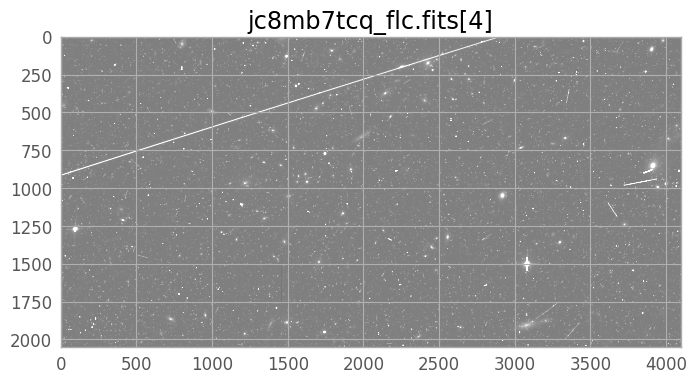

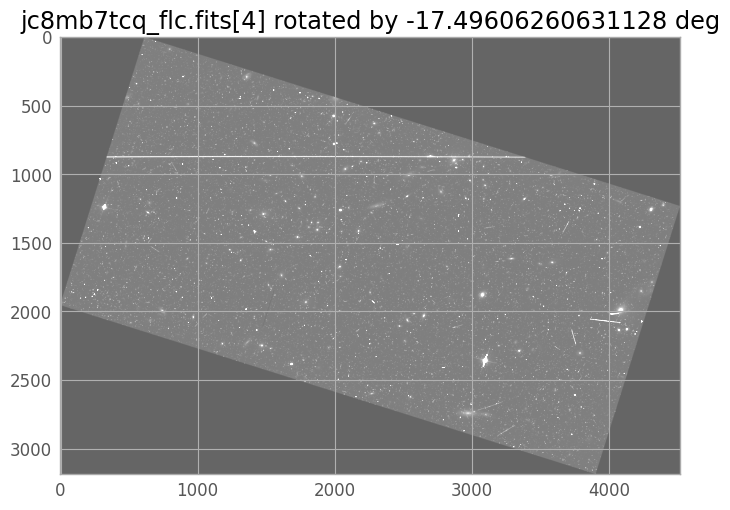

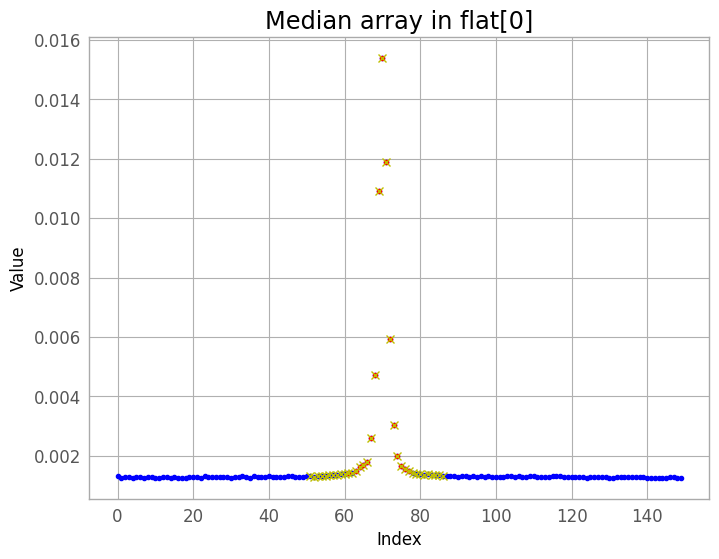

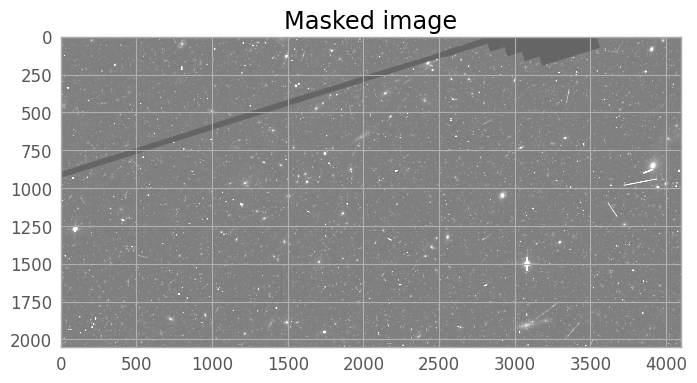

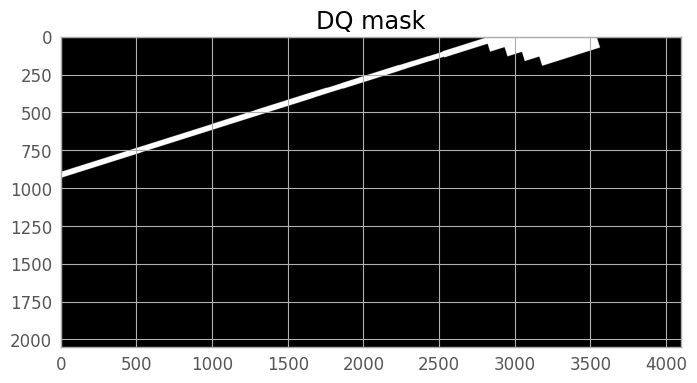

In [11]:
trail_coords = results[('jc8mb7tcq_flc.fits', 4)]
trail_segment = trail_coords[0]
trail_segment
mask_satdet = make_mask('jc8mb7tcq_flc.fits', 4, trail_segment, plot=True, verbose=True)

### Running Drizzlepac

Now that we have demonstrated both tools available to identify and mask satellite trails, we need to update the DQ arrays in the input fits file. Below is one possible command to update the DQ array with one of the masks we created above. By default, we use the mask generated by findsat_mrt, but feel free to change this. Note that if using the mask created by findsat_mrt, which was generated on a binned image, update_dq will automatically expand it to the original image dimensions.

In [12]:
final_mask = mask_mrt  # uncomment this line to use the mask from findsat_mrt
# final_mask = mask_satdet  # uncomment this line to use the mask from satdet

update_dq('jc8mb7tcq_flc.fits', 6, final_mask, verbose=True, expand_mask=True)

# note: if running findsat_mrt, you could also update the DQ array with:
# w.updatedq()

INFO:utils_findsat_mrt:Inconsistent mask sizes: 
Input mask: (1024, 2048) 
DQ array: (2048, 4096)
INFO:utils_findsat_mrt:Enlarging mask to original size.


DQ flag value is 16384
Input... flagged NPIX=78836
Existing flagged NPIX=0
Newly... flagged NPIX=78836
jc8mb7tcq_flc.fits[6] updated


 With the satellite masked, the images can be drizzled again. For brevity, only the top chip (SCI,2) of the image stack will be drizzled together to make a combined product. This is controlled in `AstroDrizzle` via the `group` parameter.

In [13]:
adriz('j*flc.fits',
      output='automatic',
      runfile='',
      context=False,
      group='4',
      overwrite=True,
      build=True,
      num_cores=1,
      preserve=False,
      clean=True,
      driz_sep_bits='64,16',
      final_bits='64,16')



No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 09:30:09.045 (12/03/2024)

==== Processing Step  Initialization  started at  09:30:09.045 (12/03/2024)

Forcibly archiving original of:  jc8mb7sqq_flc.fits as  OrIg_files/jc8mb7sqq_flc.fits

Turning OFF "preserve" and "restore" actions...

Forcibly archiving original of:  jc8mb7sxq_flc.fits as  OrIg_files/jc8mb7sxq_flc.fits
Forcibly archiving original of:  jc8mb7t5q_flc.fits as  OrIg_files/jc8mb7t5q_flc.fits
Forcibly archiving original of:  jc8mb7tcq_flc.fits as  OrIg_files/jc8mb7tcq_flc.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 109.37335052701047  37.749090133805296  
CRPIX : 2061.0  1127.5  
CD1_1 CD1_2  : -2.4091784741041154e-06  -1.3678343965839381e-05  
CD2_1 CD2_2  : -1.3678343965839381e-05  2.4091784741041154e-06  
NAXIS : 4122  2255
********************************************************************************
*
*  Estimated memory usage: 

  warnings.warn(



-Generating simple FITS output: jc8mb7sqq_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in extensions [0]
Writing out image to disk: jc8mb7sqq_single_sci.fits
Writing out image to disk: jc8mb7sqq_single_wht.fits
-Generating simple FITS output: jc8mb7sxq_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in extensions [0]
Writing out image to disk: jc8mb7sxq_single_sci.fits
Writing out image to disk: jc8mb7sxq_single_wht.fits
-Generating simple FITS output: jc8mb7t5q_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in extensions [0]
Writing out image to disk: jc8mb7t5q_single_sci.fits
Writing out image to disk: jc8mb7t5q_single_wht.fits
-Generating simple FITS output: jc8mb7tcq_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in e

  _combine(arrays, out, nlow, nhigh, badmasks, funcstr)



Saving output median image to: 'automatic_med.fits'
==== Processing Step Create Median finished at 09:30:29.432 (12/03/2024)
==== Processing Step  Blot  started at  09:30:29.43 (12/03/2024)

    Blot: creating blotted image:  jc8mb7sqq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: jc8mb7sqq_sci2_blt.fits
Writing out image to disk: jc8mb7sqq_sci2_blt.fits
    Blot: creating blotted image:  jc8mb7sxq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: jc8mb7sxq_sci2_blt.fits
Writing out image to disk: jc8mb7sxq_sci2_blt.fits
    Blot: creating blotted image:  jc8mb7t5q_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: jc8mb7t5q_sci2_blt.fits
Writing out image to disk: jc8mb7t5q_sci2_blt.fits
    Blot: creating blotted image:  jc8mb7tcq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: jc8mb7tc

  warnings.warn(



-Generating multi-extension output file:  automatic_drc.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Writing out to disk: automatic_drc.fits
==== Processing Step Final Drizzle finished at 09:30:48.528 (12/03/2024)

AstroDrizzle Version 3.5.1 is finished processing at 09:30:48.529 (12/03/2024).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          2.6699 sec.
            Static Mask          0.8145 sec.
           Subtract Sky          2.0699 sec.
       Separate Drizzle          4.4793 sec.
          Create Median          10.3501 sec.
                   Blot          5.0466 sec.
                Driz_CR          4.3263 sec.
          Final Drizzle          9.7212 sec.
   ====================          ====================
                  Total          39.4777 sec.

No traile

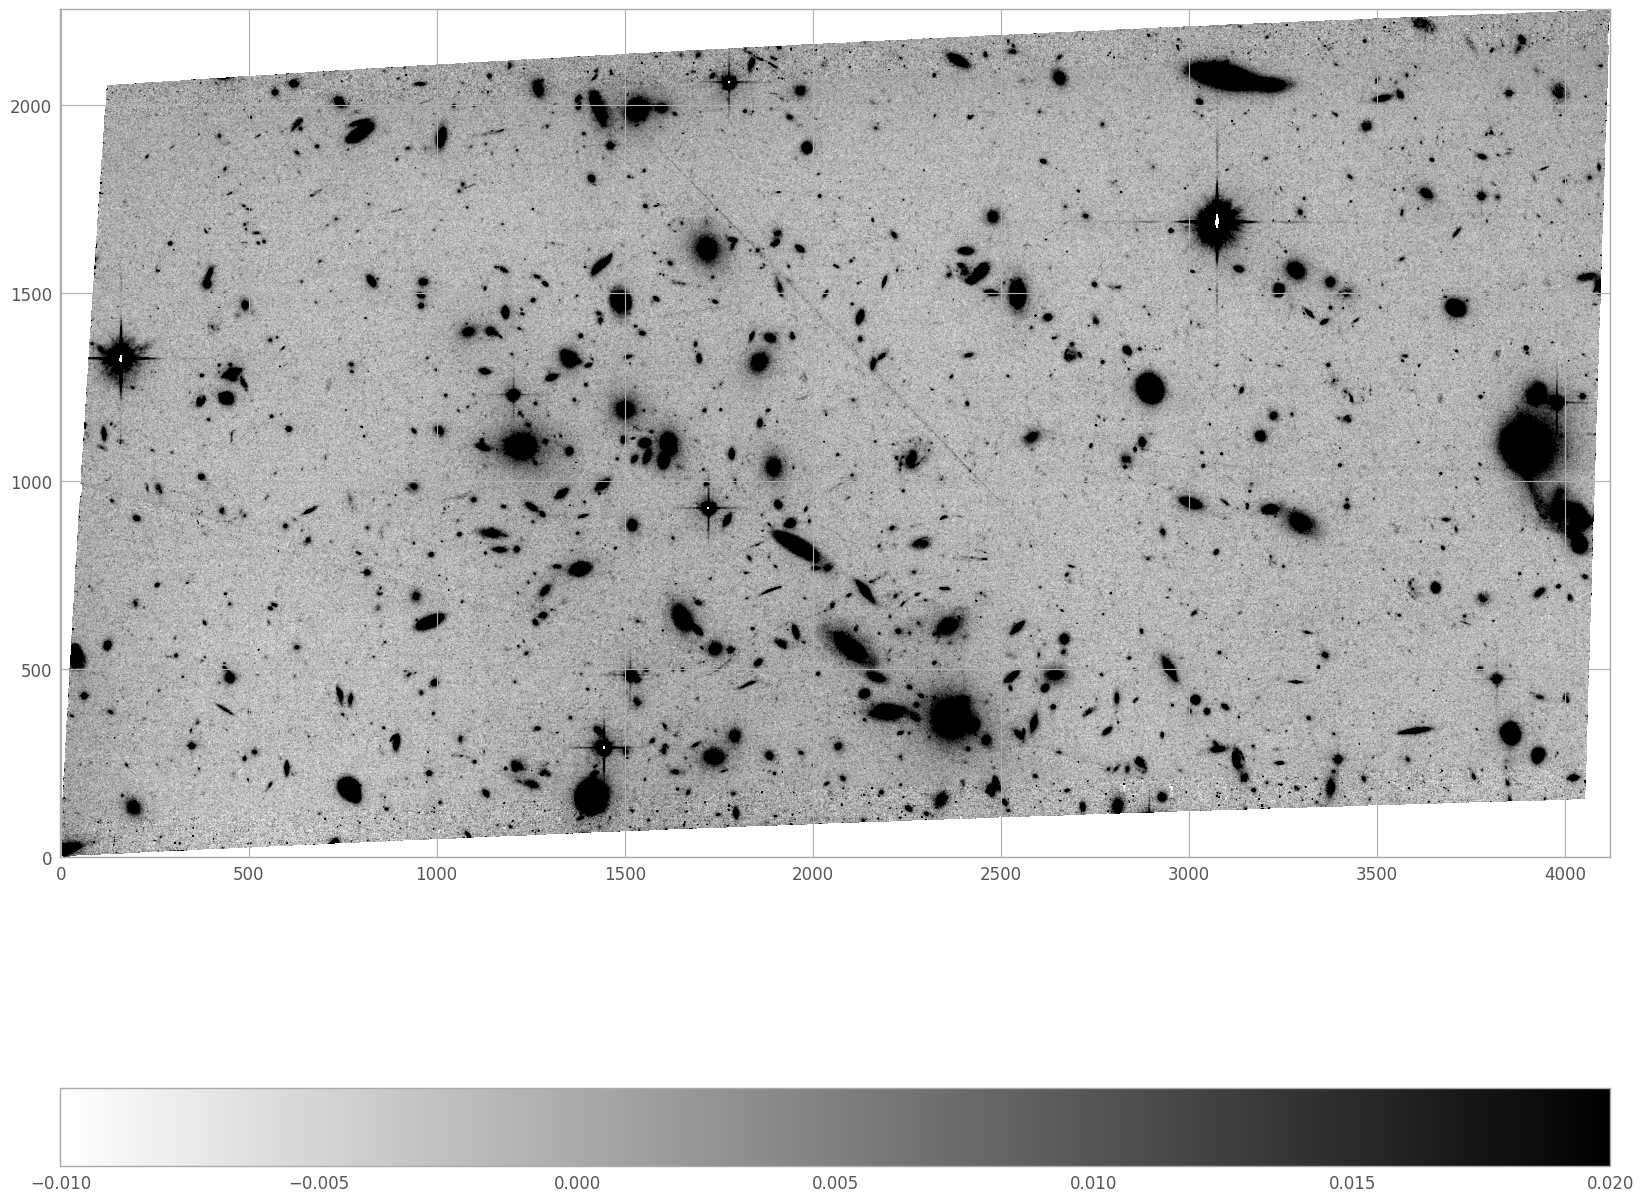

In [14]:
img = fits.getdata('automatic_drc.fits', ext=1)

norm1 = ImageNormalize(img, vmin=-0.01, vmax=0.02, stretch=LinearStretch())
plt.figure(figsize=(20, 20))
plt.imshow(img, norm=norm1, cmap='gray_r', origin='lower')
plt.colorbar(orientation='horizontal')

The final drizzled product shows that the bright satellite trail and its wings have been removed. If you don't see the full trail removed, you may need to broaden the dilate the trail further, and make sure only the four original `j*_flc.fits` images are getting incorporated into the drizzled image (if you are rerunning AstroDrizzle and are not careful with the inputs, files from previous runs could be used by accident).  

A second, fainter satellite can be seen from a different image in the stack, and this will be masked in the steps below. 

## 3. Manual masking of satellites and other anomalies

While the automatic detection algorithm flagged and masked the large satellite trail, the image above shows a second trail from a different image in the stack. 

To get rid of this trail, we will demonstrate how a DS9 regions can be used. The example image displayed below shows a region around a satellite trail. 

This region was saved in image coordinates. **NOTE THAT REGIONS SAVED IN SKY COORDINATES WILL NOT WORK FOR THIS EXAMPLE**. Below is the contents of the region file.

```
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
polygon(1476.9255,1816.4415,1545.7465,1818.5921,2825.3869,485.1853,2765.1685,480.88399)
```

The `pyregion` package will be used to make masks out of region files. For details on how to use this package go [here](https://pyregion.readthedocs.io/en/latest/). (*This package will eventually be superseded by the astropy affiliated `regions` package*.)

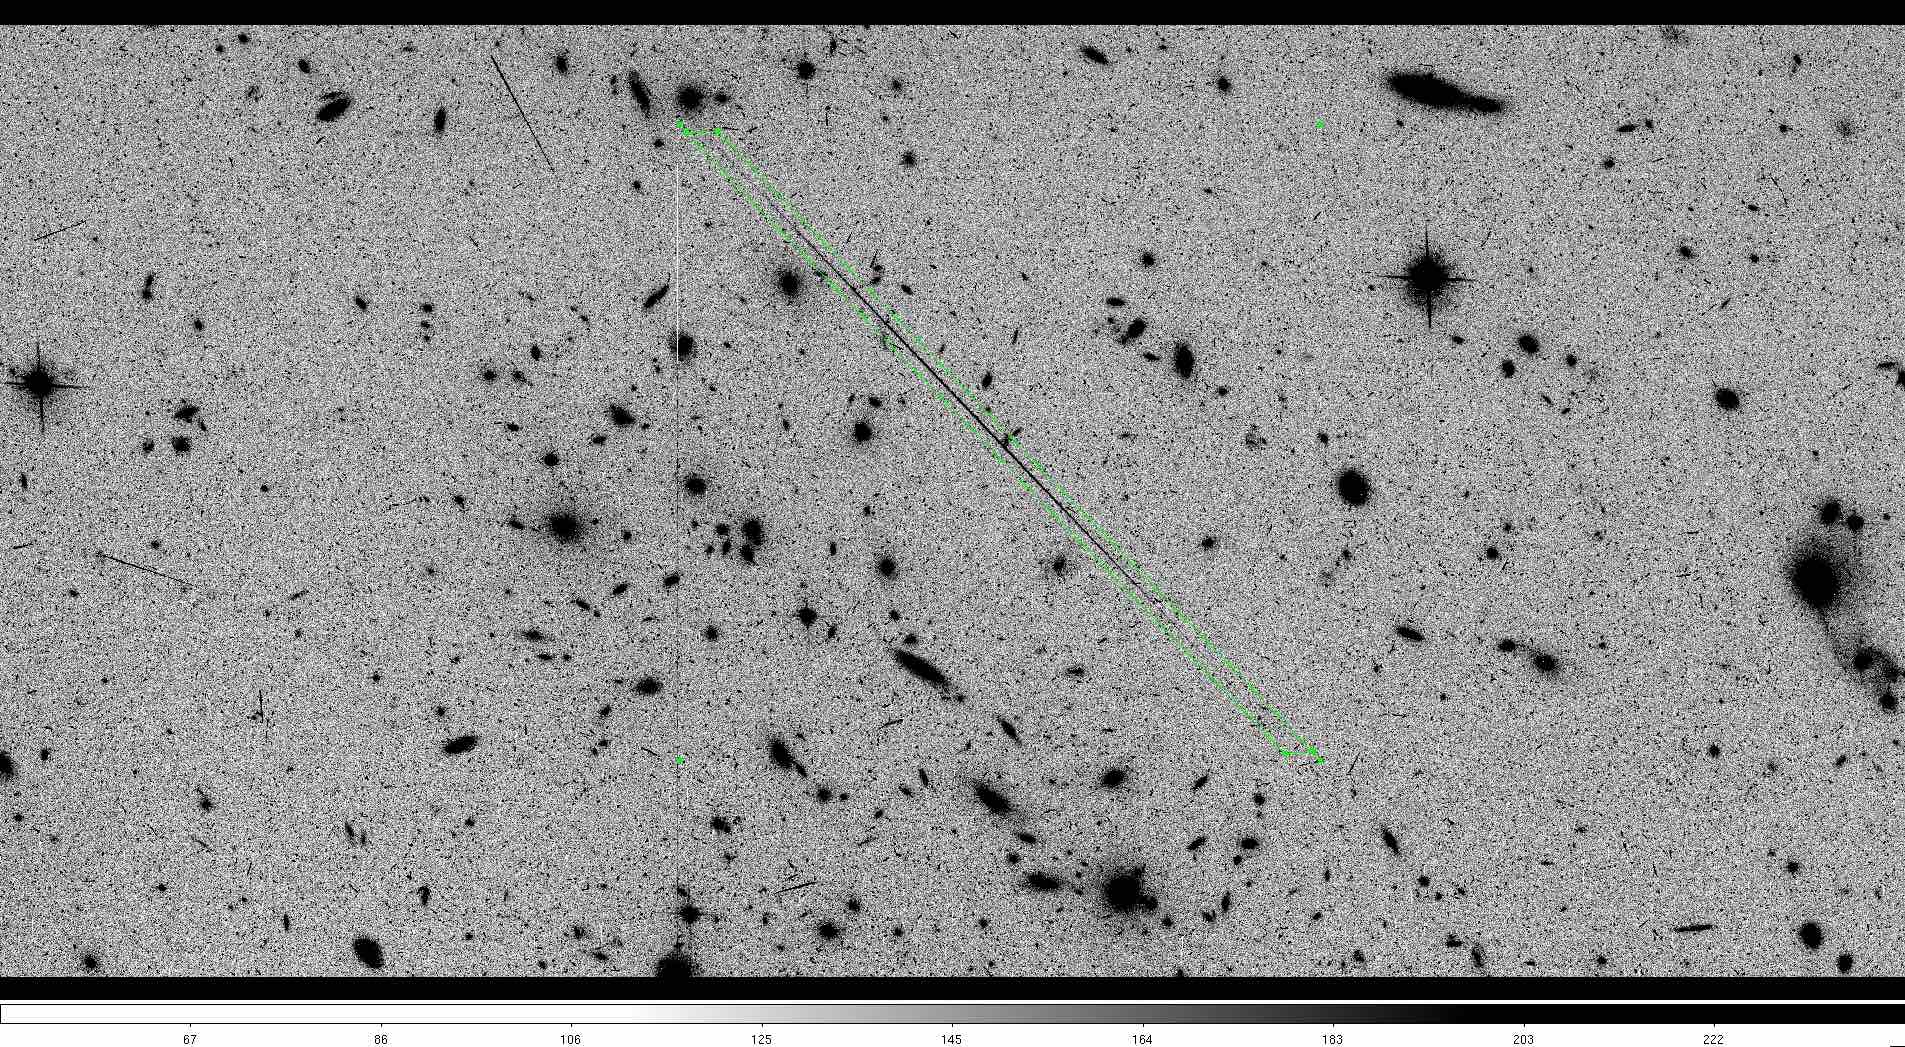

In [15]:
Image(filename='sat.jpeg')

Text(0.5, 1.0, 'DQ array of jc8mb7t5q_flc.fits[6] showing masked pixels')

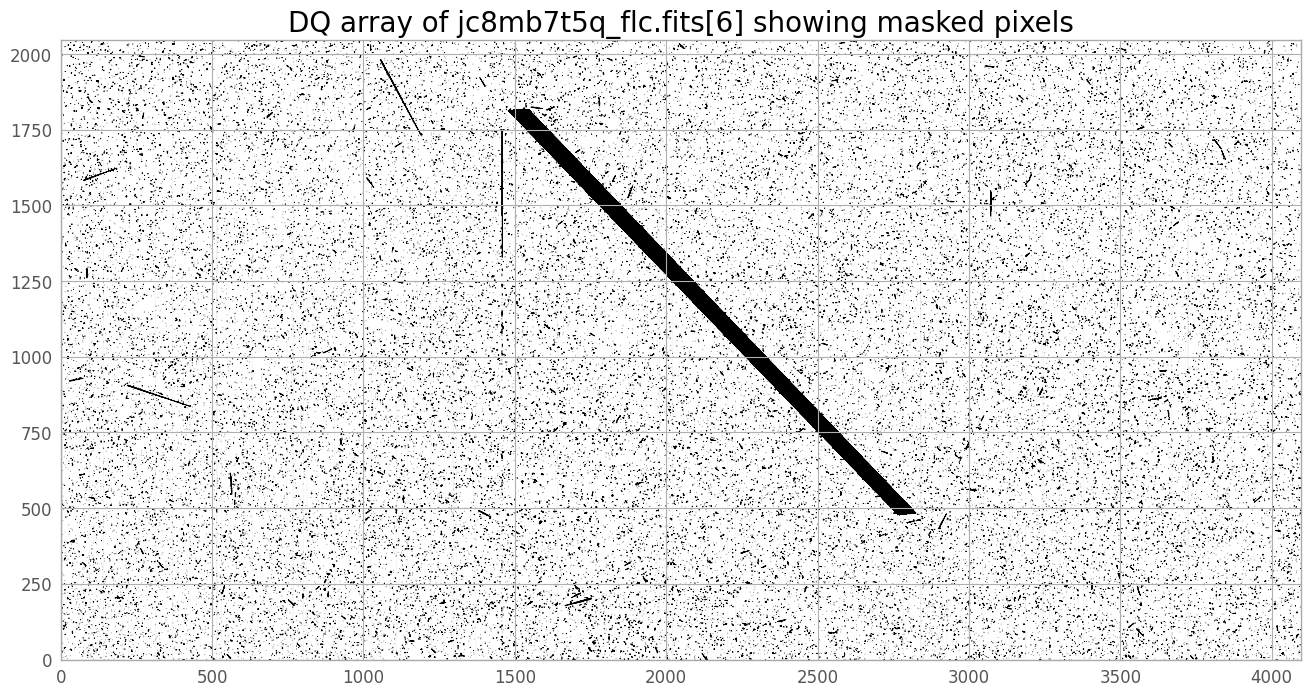

In [16]:
# Reading region file
reg_file = pyregion.parse('''# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
polygon(1476.9255,1816.4415,1545.7465,1818.5921,2825.3869,485.1853,2765.1685,480.88399)''')

# Making mask out of region file and masking DQ array
with fits.open('jc8mb7t5q_flc.fits', mode='update') as hdu:

    dq = hdu[6].data
    mask = reg_file.get_mask(shape=dq.shape)
    dq[mask] |= 16384      
        
norm1 = ImageNormalize(img, vmin=0, vmax=1000, stretch=LinearStretch())
plt.figure(figsize=(16, 10))
plt.imshow(dq, norm=norm1, cmap='gray_r', origin='lower')
plt.title('DQ array of jc8mb7t5q_flc.fits[6] showing masked pixels', fontsize=20)

With the satellite masked, the full set of images can be drizzled once more. 

In [ ]:
adriz('j*flc.fits',
      output='manual',
      runfile='',
      context=False,
      group='4',
      build=True,
      num_cores=1,
      preserve=False,
      clean=True,
      driz_sep_bits='16, 64',
      final_bits='16, 64')

No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 09:30:52.059 (12/03/2024)

==== Processing Step  Initialization  started at  09:30:52.059 (12/03/2024)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 109.37335052701047  37.749090133805296  
CRPIX : 2061.0  1127.5  
CD1_1 CD1_2  : -2.4091784741041154e-06  -1.3678343965839381e-05  
CD2_1 CD2_2  : -1.3678343965839381e-05  2.4091784741041154e-06  
NAXIS : 4122  2255
********************************************************************************
*
*  Estimated memory usage:  up to 170 Mb.
*  Output image size:       4122 X 2255 pixels. 
*  Output image file:       ~ 106 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step Initialization finished at 09:30:53.989 (12/03/2024)
==== Processing Step  Static Mask  started at  09:30:53.989 (12/03/2024)

==== Processing Step Static Ma

  warnings.warn(



-Generating simple FITS output: jc8mb7sqq_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in extensions [0]
Writing out image to disk: jc8mb7sqq_single_sci.fits
Writing out image to disk: jc8mb7sqq_single_wht.fits
-Generating simple FITS output: jc8mb7sxq_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in extensions [0]
Writing out image to disk: jc8mb7sxq_single_sci.fits
Writing out image to disk: jc8mb7sxq_single_wht.fits
-Generating simple FITS output: jc8mb7t5q_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in extensions [0]
Writing out image to disk: jc8mb7t5q_single_sci.fits
Writing out image to disk: jc8mb7t5q_single_wht.fits
-Generating simple FITS output: jc8mb7tcq_single_sci.fits
Deleted all instances of WCS with key A in extensions [0]
Deleted all instances of WCS with key B in e

  _combine(arrays, out, nlow, nhigh, badmasks, funcstr)



The new drizzled product shows that the second satellite trail and its wings have been removed.

In [ ]:
img = fits.getdata('manual_drc.fits', ext=1)

norm1 = ImageNormalize(img, vmin=-0.01, vmax=0.02, stretch=LinearStretch())
plt.figure(figsize=(20, 20))
plt.imshow(img, norm=norm1, cmap='gray_r', origin='lower')
plt.colorbar(orientation='horizontal')
plt.grid()

## About this Notebook

    Author: R. Avila, STScI ACS Team  
    Updated: December 14, 2018
    Updated: June 12, 2023 by A. O'Connor, STScI WFC3 Team 
    Updated: Feb 9, 2024 by D. Stark, STScI ACS Team